# PDE-FIND for Burger's Equation

This notebook demonstrates PDE-FIND on Burger's equation with an added diffusive term.
$$
u_t + uu_x = 0.1u_{xx}
$$
The solution given is a single travelling wave, starting out as a Gaussian.

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
import matplotlib.pyplot as plt
import warnings; warnings.filterwarnings("ignore")

import numpy as np
from numpy.random import default_rng
import pandas as pd

import os
import sys; sys.path.append('../')
from PDE_FIND import *

import sys; sys.path.append('../../parametric-discovery/')
from best_subset import *
from frols import frols
from p_linear_regression import PLinearRegression
from r_pca import R_pca
from pde_diff_new import RPCA

import scipy.io as sio
from scipy.signal import savgol_filter, wiener
from scipy.integrate import trapz
import itertools

from sklearn.preprocessing import normalize
from sklearn.linear_model import Ridge, BayesianRidge, LinearRegression as SkLinearRegression
from sklearn.base import BaseEstimator
from sklearn.pipeline import make_pipeline
from sklearn.metrics import mean_squared_error
from abess.linear import LinearRegression
import pysindy as ps

from os.path import join as join_path
FIGURE_EXPORT_PATH = "/Users/pongpisit/Documents/figure_export/"

def evaluate_coefficients(prediected_coeffs):
    GROUND = np.array([0.1, -1])
    errs = 100*np.abs(GROUND-np.array(prediected_coeffs).flatten())/np.abs(GROUND)
    return errs.mean(), errs.std()

from sympy import symbols, simplify, lambdify
from mathparser import math_eval
from varname import nameof
from misc import h5file

from findiff import FinDiff
from tqdm import tqdm, trange

Sklearn's version: 1.2.2
mrmr is not installed in the env you are using. This may cause an error in future if you try to use the (missing) lib.
sympytorch is not installed, hence its disabled functionality


In [2]:
data = sio.loadmat('../Datasets/burgers.mat')
u = (data['usol']).real
x = (data['x'][0]).real
t = (data['t'][:,0]).real
dt = t[1]-t[0]
dx = x[2]-x[1]
X, T = np.meshgrid(x, t)
XT = np.asarray([X, T]).T

In [3]:
library_functions = [lambda x: x, lambda x: x * x]
library_function_names = [lambda x: x, lambda x: x + x]
pde_lib = ps.PDELibrary(
    library_functions=library_functions,
    function_names=library_function_names,
    derivative_order=2,
    spatial_grid=x,
    is_uniform=True,
)

print('STLSQ model: ')
optimizer = ps.STLSQ(threshold=0.1, alpha=1e-5, normalize_columns=False)
model = ps.SINDy(feature_library=pde_lib, optimizer=optimizer)
model.fit(np.expand_dims(u, -1), t=dt)
model.print()

STLSQ model: 
(x0)' = 0.100 x0_11 + -1.001 x0x0_1


## Construct $\Theta (U)$ and compute $U_t$

The function build_linear_system does this for us.  We specify <br>
D = highest derivative to appear in $\Theta$  <br>
P = highest degree polynomial of $u$ to appear in $\Theta$ (not including multiplication by a derivative.  <br>
time_diff and space_diff taken via finite differences

Printed out is a list of candidate functions for the PDE.  Each is a column of $\Theta (U)$

In [4]:
Ut, R, rhs_des = build_linear_system(u, dt, dx, D=3, P=3, time_diff = 'FD', space_diff = 'FD')
rhs_des = rhs_des[1:]
R = R[:, 1:].real; Ut = Ut.real

## Solve for $\xi$

TrainSTRidge splits the data up into 80% for training and 20% for validation.  It searches over various tolerances in the STRidge algorithm and finds the one with the best performance on the validation set, including an $\ell^0$ penalty for $\xi$ in the loss function.

In [5]:
# Solve with STRidge
w = TrainSTRidge(R,Ut,10**-5,0.1)
print("PDE derived using STRidge")
print_pde(w, rhs_des)

l0_penalty: 1.6123253173828125
PDE derived using STRidge
u_t = (-1.000403 +0.000000i)uu_{x}
    + (0.100145 +0.000000i)u_{xx}
   


## Now identify the same dynamics but with added noise.

The only difference from above is that finite differences work poorly for noisy data so here we use polynomial interpolation.  With deg_x or deg_t and width_x or width_t we specify the degree number of points used to fit the polynomials used for differentiating x or t.  Unfortunately, the result can be sensitive to these.

In [6]:
# K = 2000 experiments
# weak lib only can tolerate up to 75 (maybe more?)
# weak lib + KalmanDiff: 90 (maybe more?)
# weak lib + KalmanDiff + Robust PCA: 110
# set np.random.seed(0) to reproduce...
np.random.seed(0)
noise_lv = float(30)
print(noise_lv)
noise = 0.01*np.abs(noise_lv)*(u.std())*np.random.randn(u.shape[0],u.shape[1])
un = u + noise
np.mean(noise), np.std(noise), np.max(noise), np.min(noise)

30.0


(-0.00013077012953346547,
 0.05394066850914703,
 0.2085282972955366,
 -0.24198836854079248)

In [7]:
Utn, Rn, rhs_des = build_linear_system(un, dt, dx, D=3, P=3, time_diff = 'poly',
                                       deg_x = 4, deg_t = 4, 
                                       width_x = 10, width_t = 10)
rhs_des = rhs_des[1:]
Rn = Rn[:, 1:].real; Utn = Utn.real

In [8]:
# Solve with STRidge
w = TrainSTRidge(Rn,Utn,10**-5,1)
print("PDE derived using STRidge")
print_pde(w, rhs_des)

l0_penalty: 1.93969921875
PDE derived using STRidge
u_t = (-0.775461 +0.000000i)uu_{x}
   


## Getting started

In [9]:
# ## Goals: implement my own optimizer and differentiation_method class!
# from functools import partial
# import derivative
# from tvregdiff import TVRegDiff, tvregdiff, numdiff, pysindydiff, savgol_denoise

# class KalmanDiff(ps.BaseDifferentiation):
#     def __init__(self, alpha, poly_deg=None, rpca_lambda=None, d=1, axis=1, is_uniform=True, periodic=False):
#         super(KalmanDiff, self).__init__()
#         # Kalman diff
#         self.alpha = alpha
#         self.diff_func = derivative.Kalman(alpha=self.alpha)
#         self.d = d
#         self.diff = partial(pysindydiff, **{"diff_method":self.diff_func, "order":self.d})
#         # Savgol denoising
#         self.poly_deg = poly_deg
#         if poly_deg is not None:
#             if poly_deg%2 == 0: window_length = self.poly_deg + 1
#             else: window_length = self.poly_deg + 2
#             self.denoise = partial(savgol_denoise, **{"window_length":window_length, "poly_deg":self.poly_deg})
#         else:
#             self.denoise = lambda _: _
#         # Robust PCA
#         self.rpca_lambda = rpca_lambda
#         # Other info...
#         self.axis = axis
#         self.is_uniform = is_uniform
#         self.periodic = periodic
#         # data transformation
#         # rs = np.ones(2).astype(np.int32); rs[self.axis] = -1; rs = tuple(rs)
#         self.transform = np.vectorize(composite_function(self.diff, self.denoise, left2right=True), signature="(m),(m)->(m)")
#     # _differentiate
#     def _differentiate(self, x, t):
#         in_shape = x.shape
#         if len(in_shape) == 2: x = np.expand_dims(x, -1) # x should now be 3-dimensional
#         if isinstance(t, float) and self.is_uniform: 
#             t = np.linspace(0, stop=t*(x.shape[self.axis]-1), num=x.shape[self.axis])
#         out = []
#         # wrt to x var
#         if self.axis == 0:
#             for i in range(x.shape[-1]):
#                 # use lambda and partial from functools to help shorten the code
#                 # diff = np.hstack([self.denoise(self.diff(x[:, j:j+1, i], t)).reshape(-1, 1) 
#                 #                   for j in range(x.shape[1])])
#                 # diff = np.hstack([self.transform(x[:, j:j+1, i], t) for j in range(x.shape[1])])
#                 # diff = np.vectorize(self.transform, signature="(m),(m)->(m)")(x[:,:,i].T, t).T
#                 diff = self.transform(x[:,:,i].T, t).T
#                 if self.rpca_lambda is not None:
#                     diff = self._get_low_rank(diff)
#                 out.append(np.expand_dims(diff, axis=-1))
#         # wrt to time var
#         elif self.axis == 1:
#             for i in range(x.shape[-1]):
#                 # use lambda and partial from functools to help shorten the code
#                 # diff = np.vstack([self.denoise(self.diff(x[j:j+1, :, i], t)).reshape(1, -1) 
#                 #                   for j in range(x.shape[0])])
#                 # diff = np.vstack([self.transform(x[j:j+1, :, i], t) for j in range(x.shape[0])])
#                 # diff = np.vectorize(self.transform, signature="(m),(m)->(m)")(x[:,:,i], t)
#                 diff = self.transform(x[:,:,i], t)
#                 if self.rpca_lambda is not None:
#                     diff = self._get_low_rank(diff)
#                 out.append(np.expand_dims(diff, axis=-1))
#         return np.concatenate(out, axis=-1).reshape(in_shape)
#     # _get_low_rank
#     def _get_low_rank(self, x):
#         rpca = RobustPCA(lamb=self.rpca_lambda, tol=10, use_fbpca=True, max_iter=int(1e6))
#         rpca.fit(x)
#         return rpca.get_low_rank()

#### RPCA before Savgol (Best with window length = 11, Seems fine)

In [10]:
rpca_lambda = None; apply_savgol = False
un_copy = un.copy()

In [11]:
if rpca_lambda is not None:
    rpca = RobustPCA(lamb=rpca_lambda, tol=10, use_fbpca=True, max_iter=int(1e4))
    rpca.fit(un)
    un = rpca.get_low_rank()
    est_noise = un_copy-un
    print(np.mean(est_noise), np.std(est_noise), np.max(est_noise), np.min(est_noise))
    print(mean_squared_error(un, u))
else:
    ### noise40 ###
    # un = sio.loadmat("../Datasets/l1rdae_noisy_burgers.mat")["rdae_denoised_un"].real
    # un = sio.loadmat("../Datasets/rdae_noisy_burgers_best.mat")["rdae_denoised_un"].real    
    # un = sio.loadmat("../RDAE_data/l21rdae_noisy40_burgers_0.5.mat")["rdae_denoised_un"].real # best
    # un = sio.loadmat("../RDAE_data/l21rdae_noisy40_burgers_0.05.mat")["rdae_denoised_un"].real
    
    ### noise30 ###
    # un = sio.loadmat("../RDAE_data/l21rdae_noisy30_burgers_5.0.mat")["rdae_denoised_un"].real # BIC slope = -9600.72546420795
    # un = sio.loadmat("../RDAE_data/l21rdae_noisy30_burgers_1.0.mat")["rdae_denoised_un"].real # BIC slope = -9707.105703779773
    # un = sio.loadmat("../RDAE_data/l21rdae_regression_noisy30_burgers_1.0.mat")["rdae_denoised_un"].real
    # un = sio.loadmat("../RDAE_data/l21rdae_noisy30_burgers_0.5.mat")["rdae_denoised_un"].real # BIC slope = -9778.44580594571
    # un = sio.loadmat("../RDAE_data/l21rdae_regression_noisy30_burgers_0.5.mat")["rdae_denoised_un"].real
    # un = sio.loadmat("../RDAE_data/l21rdae_noisy30_burgers_0.05.mat")["rdae_denoised_un"].real # BIC slope = -9766.93551576839
    # un = sio.loadmat("../RDAE_data/l21rdae_noisy30_burgers_0.005.mat")["rdae_denoised_un"].real # BIC slope = -1346.286018082552    
    
    ### noise30 | pytroch ###
    # RDAE_lambda = 1.0
    # un = np.load(f"../RDAE_data/pytorch/burgers_RDAE_denoised30_lambda{RDAE_lambda}.npy")
    
    ### noise30 | ksvd ###
    denoising_mode = 'dctksvd_reg' # ksvd, dictionary_learning
    n_components = 32
    smoother_name = 'none' # none, lowess, kalman, gaussian, filterpy
    transform_n_nonzero = "_none" # '1'
    un = np.load(f"../RDAE_data/{denoising_mode}/{smoother_name}/transform_n_nonzero_coefs{transform_n_nonzero}/burgers_dictlearn_denoised30_components{n_components}_8x8.npy")

# divide into 2 5 10
if apply_savgol:
    un_savgol = np.vstack([savgol_denoise(un[i:i+1, :], 11, 2) for i in range(un.shape[0])])
    print(mean_squared_error(u, un_savgol))
    un = un_savgol

#### Avg weak coef from 10 runs

In [12]:
# kalpha = 1e-1; poly_deg = None; diff_order = 2
# differentiation_method = KalmanDiff
# differentiation_kwargs = {"alpha":kalpha, "poly_deg":poly_deg, "rpca_lambda":None}

poly_deg = None; diff_order = 2
differentiation_method = ps.FiniteDifference
differentiation_kwargs = {}

In [13]:
weak_pde_lib = ps.WeakPDELibrary(library_functions=[lambda x: x, lambda x: x * x], 
                                 function_names=[lambda x: x, lambda x: x + x], 
                                 derivative_order=diff_order, p=diff_order, 
                                 spatiotemporal_grid=XT, 
                                 include_bias=False, is_uniform=True, K=10000, # new random K points in every calls to the ps.WeakPDELibrary
                                 differentiation_method=differentiation_method, 
                                )
kwargs = {'fit_intercept':False, 'copy_X':True, 'normalize_columns':False}
X_pre, y_pre, fns = ps_features(un, t, weak_pde_lib, kwargs)

differentiation method or differentiation_kwargs is not implemented in feature_library.


In [17]:
## give wrong answer
# optimizer = ps.STLSQ(threshold=0.1, alpha=1e-5, normalize_columns=True)
# optimizer = ps.SR3(threshold=0.1, thresholder='l0', tol=1e-8, normalize_columns=True, max_iter=1000)
# optimizer = ABESS(abess_kw={'alpha':1e-2, 'support_size':2, 'cv':5}, group=None, is_normal=False, normalize_columns=True)
# optimizer = BESS(bess_kw={'path_type':'seq', 'sequence':[2], 'is_cv':True, 'K':5}, is_normal=True, normalize_columns=False)

## give correct answer (for reasonable noise levels) | L0BNB & ps.FROLS are now the best algos. 
# Fit a weak form model
# optimizer = ps.SSR(criteria='model_residual', normalize_columns=True, kappa=1e-2)
# optimizer = ps.FROLS(normalize_columns=True, kappa=5e-4, max_iter=100, alpha=1e-1) # kappa = 1e-3 or 5e-4 gives 2 effective candidates
optimizer = L0BNB(max_nonzeros=2, lam=1e-3, is_normal=True, normalize_columns=False) # tune lam จาก (X_pre, y_pre) | ตอนนี้ยังไม่ได้ tune
# optimizer = BruteForceRegressor(2)
# if feature_library=weak_pde_lib, then just differentiation_method=None is fine.
n_ensemble_models = 50
model = ps.SINDy(feature_library=weak_pde_lib, optimizer=optimizer, 
                 differentiation_method=differentiation_method,
                 feature_names=['u'])
model.fit(np.expand_dims(un, -1), t=dt)

# print the model selected by Pysindy package
# (Not giving the best model if set ensemble or library_ensemble = True)
print(model.get_feature_names())
model.print()

# Use the best-performing (on any validation set) coef in model.coef_list (Plse add this functionality to pysindy)
# np.einsum('ij,jkl',X_pre,np.array(model.get_coef_list()).T) -> a cool-looking code
# from opt_einsum import contract
# contract('ij,jkl',X_pre,np.array(model.get_coef_list()).T) -> a cool-looking code
print_pde(model.get_coef_list()[np.argmin(np.sum((np.squeeze(np.tensordot(X_pre, np.array(model.get_coef_list()).T, axes=([-1], [0])), axis=1)-y_pre)**2, axis=0))].reshape(-1,1), model.get_feature_names())

OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


['u', 'uu', 'u_1', 'u_11', 'uu_1', 'uuu_1', 'uu_11', 'uuu_11']
(u)' = 0.101 u_11 + -1.005 uu_1
u_t = (0.101288 +0.000000i)u_11
    + (-1.005335 +0.000000i)uu_1
   


In [18]:
ols_model, eff_rhs_indices = model.validate_coef_list(X_pre, y_pre)[0]
print(np.array([convert2latex(f) for i,f in enumerate(model.get_feature_names()) if i in eff_rhs_indices]))
print(ols_model.params)
# (2.966546839959899, 1.8494019586055508) -> ksvd
# (2.951366904136575, 1.8846719890201133) -> spm_ksvd
# (2.0340810219237895, 1.5495206426166808) -> spm_ksvd + savgol
evaluate_coefficients(ols_model.params) # (3.05658148186686, 2.101833972875855)

hasattr threshold in optimizer...
u_t = (0.101288 +0.000000i)u_11
    + (-1.005335 +0.000000i)uu_1
   
['u_{xx}' 'uu_{x}']
[ 0.10128809 -1.0053352 ]


(0.9108044207096072, 0.3772832453250857)

In [16]:
all_ols_models = []
all_eff_rhs = []
for mnz in range(1, 9):
    optimizer = L0BNB(max_nonzeros=mnz, lam=1e-3, is_normal=True, normalize_columns=False) # tune lam จาก (X_pre, y_pre) | ตอนนี้ยังไม่ได้ tune
    n_ensemble_models = 50
    model = ps.SINDy(feature_library=weak_pde_lib, optimizer=optimizer, 
                     differentiation_method=differentiation_method, 
                     feature_names=['u'])
    model.fit(np.expand_dims(un, -1), t=dt, ensemble=True, 
              library_ensemble=True, n_candidates_to_drop=1, n_models=n_ensemble_models)
    ols_model, eff_rhs_indices = model.validate_coef_list(X_pre, y_pre, criterion='bic')[0]
    all_ols_models.append(ols_model)
    all_eff_rhs.append(eff_rhs_indices)

hasattr threshold in optimizer...
u_t = (-0.944892 +0.000000i)uu_1
   
hasattr threshold in optimizer...
u_t = (0.101288 +0.000000i)u_11
    + (-1.005335 +0.000000i)uu_1
   
hasattr threshold in optimizer...
u_t = (0.101288 +0.000000i)u_11
    + (-1.005335 +0.000000i)uu_1
   
hasattr threshold in optimizer...
u_t = (-0.005657 +0.000000i)uu
    + (-0.012327 +0.000000i)u_1
    + (0.098334 +0.000000i)u_11
    + (-0.972223 +0.000000i)uu_1
   
hasattr threshold in optimizer...
u_t = (-0.008759 +0.000000i)u_1
    + (0.100518 +0.000000i)u_11
    + (-0.982483 +0.000000i)uu_1
   
hasattr threshold in optimizer...
u_t = (0.016372 +0.000000i)u
    + (-0.050093 +0.000000i)uu
    + (-0.022120 +0.000000i)u_1
    + (0.095299 +0.000000i)u_11
    + (-0.938399 +0.000000i)uu_1
    + (-0.014896 +0.000000i)uuu_11
   
hasattr threshold in optimizer...
u_t = (0.015653 +0.000000i)u
    + (-0.048807 +0.000000i)uu
    + (-0.021989 +0.000000i)u_1
    + (0.095630 +0.000000i)u_11
    + (-0.938401 +0.000000i)uu_1
 

In [17]:
# u_t = (0.101288 +0.000000i)u_11
#     + (-1.005335 +0.000000i)uu_1

# u_t = (0.015653 +0.000000i)u
#     + (-0.048807 +0.000000i)uu
#     + (-0.021989 +0.000000i)u_1
#     + (0.095630 +0.000000i)u_11
#     + (-0.938401 +0.000000i)uu_1
#     + (-0.003510 +0.000000i)uu_11
#     + (-0.010700 +0.000000i)uuu_11

#### Guarantee the optimality

In [18]:
def hierarchy(fitted_model, dataset, target_index=0, field=0):
    Xd, yd = dataset
    yd = yd[:, target_index]
    model_results = {}
    for effective_indices in fitted_model:
        com = len(effective_indices)
        X_pre_sup = Xd[:, effective_indices]
        solve = np.linalg.lstsq(X_pre_sup, yd, rcond=None)
        coeff = solve[0]
        if len(solve[1]) == 1:
            mse = solve[1][0]
            if (com not in model_results) or model_results[com][-1] > mse:
                model_results[com] = effective_indices, coeff, mse
    if field < 0: 
        return model_results
    else: 
        dkeys = model_results.keys()
        dvals = (lambda lst, _: [t[_] for t in lst if len(t)>_])(model_results.values(), field)
        return dict(zip(dkeys, dvals))

In [19]:
# np.save("../Burgers_exp/IPI_output_files/X_pre.npy", X_pre)
# np.save("../Burgers_exp/IPI_output_files/y_pre.npy", y_pre)
print("From leaps")
Rdata_name = "leaps/leaps_efi_nbest10.npy"
leaps_best_subsets = np.load(os.path.join("/Users/pongpisit/Desktop/fun/R/data/Burgers/", Rdata_name))
leaps_best_subsets = [tuple(np.where(bs>0)[0]) for bs in leaps_best_subsets]
leaps_best_subsets = [e[0] for e in backward_refinement(leaps_best_subsets, (X_pre, y_pre), 
                                                        mode='SelectKBest', ic_type='bic', 
                                                        verbose=False).track.values()]
leaps_best_subsets

From leaps


[(4,),
 (3, 4),
 (2, 3, 4),
 (2, 3, 4, 7),
 (0, 1, 2, 3, 4),
 (0, 1, 2, 3, 4, 7),
 (0, 1, 2, 3, 4, 6, 7),
 (0, 1, 2, 3, 4, 5, 6, 7)]

In [20]:
print("From imsubsets")
Rdata_name = "imsubsets/imsubsets_efi.npy"
imsubsets_best_subsets = np.load(os.path.join("/Users/pongpisit/Desktop/fun/R/data/Burgers/", Rdata_name))
imsubsets_best_subsets = [tuple(np.where(bs>0)[0]) for bs in imsubsets_best_subsets]
imsubsets_best_subsets = sorted(hierarchy(imsubsets_best_subsets, (X_pre, y_pre)).values(), key=len)
imsubsets_best_subsets = [e[0] for e in backward_refinement(imsubsets_best_subsets, (X_pre, y_pre), 
                                                            mode='SelectKBest', ic_type='bic', 
                                                            verbose=False).track.values()]
imsubsets_best_subsets

From imsubsets


[(4,),
 (3, 4),
 (2, 3, 4),
 (2, 3, 4, 7),
 (0, 1, 2, 3, 4),
 (0, 1, 2, 3, 4, 7),
 (0, 1, 2, 3, 4, 6, 7),
 (0, 1, 2, 3, 4, 5, 6, 7)]

In [21]:
print("From brute-force solver")
brute_best_subsets = [tuple(np.where(abs(brute_force(X_pre, y_pre, support_size=i).flatten())>0)[0])
                      for i in range(1, X_pre.shape[1]+1)]
brute_best_subsets
brute_best_subsets

From brute-force solver


[(4,),
 (3, 4),
 (2, 3, 4),
 (2, 3, 4, 7),
 (0, 1, 2, 3, 4),
 (0, 1, 2, 3, 4, 7),
 (0, 1, 2, 3, 4, 6, 7),
 (0, 1, 2, 3, 4, 5, 6, 7)]

In [22]:
Rdata_name = "bestsubset"
print(f"From {Rdata_name}")
Rdata_name = f"{Rdata_name}/{Rdata_name}_efi.npy"
bestsubset_best_subsets = np.load(os.path.join("/Users/pongpisit/Desktop/fun/R/data/Burgers/", Rdata_name))
bestsubset_best_subsets = [tuple(np.where(bs>0)[0]) for bs in bestsubset_best_subsets]
bestsubset_best_subsets = [e[0] for e in backward_refinement(bestsubset_best_subsets, (X_pre, y_pre), 
                                                             mode='SelectKBest', ic_type='bic', 
                                                             verbose=False).track.values()]
bestsubset_best_subsets

From bestsubset


[(4,),
 (3, 4),
 (2, 3, 4),
 (2, 3, 4, 7),
 (0, 1, 2, 3, 4),
 (0, 1, 2, 3, 4, 7),
 (0, 1, 2, 3, 4, 6, 7),
 (0, 1, 2, 3, 4, 5, 6, 7)]

In [23]:
Rdata_name = "l0learn"
print(f"From {Rdata_name}")
Rdata_name = f"{Rdata_name}/{Rdata_name}_efi.npy"
l0learn_best_subsets = np.load(os.path.join("/Users/pongpisit/Desktop/fun/R/data/Burgers/", Rdata_name))
l0learn_best_subsets = [tuple(np.where(bs>0)[0]) for bs in l0learn_best_subsets if sum(bs)>0]
l0learn_best_subsets = sorted(hierarchy(l0learn_best_subsets, (X_pre, y_pre)).values(), key=len)
l0learn_best_subsets = [e[0] for e in backward_refinement(l0learn_best_subsets, (X_pre, y_pre), 
                                                          mode='SelectKBest', ic_type='bic', 
                                                          verbose=False).track.values()]
l0learn_best_subsets

From l0learn


[(4,),
 (3, 4),
 (2, 3, 4),
 (2, 3, 4, 7),
 (0, 1, 2, 3, 4),
 (0, 1, 2, 3, 4, 7),
 (0, 1, 2, 3, 4, 6, 7),
 (0, 1, 2, 3, 4, 5, 6, 7)]

In [24]:
Rdata_name = "abess"
print(f"From {Rdata_name}")
Rdata_name = f"{Rdata_name}/{Rdata_name}_efi.npy"
abess_best_subsets = np.load(os.path.join("/Users/pongpisit/Desktop/fun/R/data/Burgers/", Rdata_name))
abess_best_subsets = [tuple(np.where(bs>0)[0]) for bs in abess_best_subsets if sum(bs)>0]
abess_best_subsets = sorted(hierarchy(abess_best_subsets, (X_pre, y_pre)).values(), key=len)
abess_best_subsets = [e[0] for e in backward_refinement(abess_best_subsets, (X_pre, y_pre), 
                                                        mode='SelectKBest', ic_type='bic', 
                                                        verbose=False).track.values()]
abess_best_subsets

From abess


[(4,),
 (3, 4),
 (2, 3, 4),
 (2, 3, 4, 7),
 (0, 1, 2, 3, 4),
 (0, 1, 2, 3, 4, 7),
 (0, 1, 2, 3, 4, 6, 7),
 (0, 1, 2, 3, 4, 5, 6, 7)]

In [25]:
print("Leaps in R package got wrong!?")
for leaps_indices, imsubsets_indices, brute_indices in zip(leaps_best_subsets, imsubsets_best_subsets, brute_best_subsets):
    if (leaps_indices != brute_indices) or (leaps_indices != brute_indices):
        print(leaps_indices, brute_indices)

Leaps in R package got wrong!?


In [26]:
all_eff_rhs.append(tuple(i for i in range(X_pre.shape[1])))
all_eff_rhs.extend(leaps_best_subsets)

In [27]:
ic_type = 'bic'; mode='rfe' # aic, bic | rfe, SelectKBest

# st += backward_refinement(all_eff_rhs, (normalize(X_pre, axis=0), y_pre), 
#                           mode=mode, ic_type=ic_type, verbose=True)

st = backward_refinement(all_eff_rhs, (X_pre, y_pre), 
                         mode=mode, ic_type=ic_type, verbose=False)
st.track

{1: ((4,), -65223.31323032364),
 2: ((3, 4), -77439.44760272012),
 4: ((2, 3, 4, 7), -77447.20457263225),
 3: ((2, 3, 4), -77441.5826689938),
 6: ((0, 1, 2, 3, 4, 7), -77456.32325949248),
 5: ((0, 1, 2, 3, 4), -77459.16716992913),
 7: ((0, 1, 2, 3, 4, 6, 7), -77447.7671773212),
 8: ((0, 1, 2, 3, 4, 5, 6, 7), -77438.56630211977)}

#### Find decreasing aics and plot

In [28]:
decreasing_aics = []
complexities = []
eff_feature_names = []
now_aic = 1e6
for com in sorted(st.track.keys()):
    indices, aic = st.track[com]
    print(indices)
    if aic < now_aic:
        complexities.append(len(indices))
        decreasing_aics.append(aic)
        eff_feature_names.append([convert2latex(f) for i,f in enumerate(model.get_feature_names()) if i in indices])
        now_aic = aic
decreasing_aics = np.array(decreasing_aics)
complexities = np.array(complexities)
relative_decreasing_aics = decreasing_aics-np.min(decreasing_aics)

(4,)
(3, 4)
(2, 3, 4)
(2, 3, 4, 7)
(0, 1, 2, 3, 4)
(0, 1, 2, 3, 4, 7)
(0, 1, 2, 3, 4, 6, 7)
(0, 1, 2, 3, 4, 5, 6, 7)


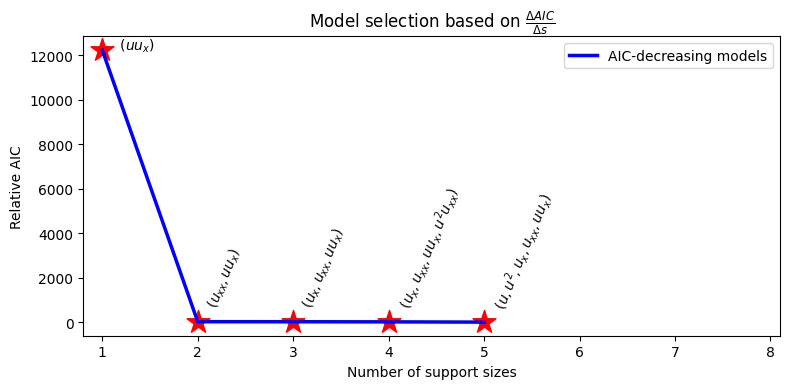

In [29]:
fig, ax = plt.subplots(figsize=(8,4))
ax.plot(complexities, relative_decreasing_aics, color='blue', linewidth=2.5, label="AIC-decreasing models")
ax.scatter(complexities, relative_decreasing_aics, marker='*', c='red', s=300)
for com, name, rel_aic in zip(complexities, eff_feature_names, relative_decreasing_aics):
    rotation = (90+45)/2
    if com == 1: rotation = 0
    ax.annotate(f"    $({','.join(name)})$", (com, rel_aic), rotation=rotation)
plt.xlim(0.8,8.1)
plt.title(r"Model selection based on $\frac{\Delta AIC}{\Delta s}$")
plt.ylabel("Relative AIC")
plt.xlabel("Number of support sizes")
plt.legend()
plt.tight_layout()
# plt.savefig(join_path(FIGURE_EXPORT_PATH, "aic_model_selection.png"), dpi=300)
plt.show()

In [30]:
good_coms = set()
min_pok = 0.01
max_pok = 1./2
delta_pok = min_pok
for p in np.arange(min_pok, max_pok+delta_pok, delta_pok):
    c = find_transition_V5(decreasing_aics, complexities, percent_ok=p)
    if c == 1: break
    good_coms.add(c)
good_coms

2 improves 1
Percent improve: 0.1872970532677102
5 does not improve 2
Percent improve: 8.488166268171171e-05
2 improves 1
Percent improve: 0.1872970532677102
5 does not improve 2
Percent improve: 8.488166268171171e-05
2 improves 1
Percent improve: 0.1872970532677102
5 does not improve 2
Percent improve: 8.488166268171171e-05
2 improves 1
Percent improve: 0.1872970532677102
5 does not improve 2
Percent improve: 8.488166268171171e-05
2 improves 1
Percent improve: 0.1872970532677102
5 does not improve 2
Percent improve: 8.488166268171171e-05
2 improves 1
Percent improve: 0.1872970532677102
5 does not improve 2
Percent improve: 8.488166268171171e-05
2 improves 1
Percent improve: 0.1872970532677102
5 does not improve 2
Percent improve: 8.488166268171171e-05
2 improves 1
Percent improve: 0.1872970532677102
5 does not improve 2
Percent improve: 8.488166268171171e-05
2 improves 1
Percent improve: 0.1872970532677102
5 does not improve 2
Percent improve: 8.488166268171171e-05
2 improves 1
Percen

{2}

In [31]:
print(smoother_name, n_components)
print(decreasing_aics[1]-decreasing_aics[0])
decreasing_aics, complexities, eff_feature_names

none 32
-12216.134372396475


(array([-65223.31323032, -77439.44760272, -77441.58266899, -77447.20457263,
        -77459.16716993]),
 array([1, 2, 3, 4, 5]),
 [['uu_{x}'],
  ['u_{xx}', 'uu_{x}'],
  ['u_{x}', 'u_{xx}', 'uu_{x}'],
  ['u_{x}', 'u_{xx}', 'uu_{x}', 'u^2u_{xx}'],
  ['u', 'u^2', 'u_{x}', 'u_{xx}', 'uu_{x}']])

#### More model selection

In [32]:
# Use PDE_FIND_Loss from parametric_pde_find.py by formulating as a parametric problem
# Moving horizon in time

def ssr2llf(ssr, nobs):
    nobs2 = nobs / 2.0
    llf = -nobs2 * np.log(2 * np.pi) - nobs2 * np.log(ssr / nobs) - nobs2
    return llf

def log_like_value(prediction, ground):                                                                                                               
    nobs = float(ground.shape[0])
    ssr = np.sum(np.abs(ground - prediction)**2)
    return ssr2llf(ssr, nobs)

def BIC_AIC(prediction, ground, nparams, reg_func = lambda x: x):
    nparams = reg_func(nparams)
    llf = log_like_value(prediction, ground)
    return -2*llf + np.log(ground.shape[0])*nparams, -2*llf + 2*nparams

def AIC_Loss(A,b,x,epsilon=1e-5):
    N = A.shape[0]
    k = np.count_nonzero(x)
    # Rudy et al., 2019
    rss = ((b-A.dot(x))**2).sum()
    aic = N*np.log(rss/N+epsilon) + 2*k + (2*k**2+2*k)/(N-k-1)
    return aic

def PDE_FIND_Loss(As,bs,x,epsilon=1e-5,const_coeff=True,cv=0,ic_type="bic",version=0):
    # D: Number of candidates | m: either len(t) or len(x) (temporal or spatial group)
    D,m = x.shape
    # n: Number of horizon
    n,_ = As[0].shape
    N = n*m
    
    rss = [np.linalg.norm(bs[j] - As[j].dot(x[:,j].reshape(D,1)))**2 for j in range(m)]
    rss = np.sum(rss)
    llf = ssr2llf(rss, N)
    
    k = np.count_nonzero(x)
    if const_coeff:
        k = np.count_nonzero(x)/m
    k = k + k*cv
    
    if ic_type == "aic":
        aic1 = N*np.log(rss/N+epsilon) + 2*k + (2*k**2+2*k)/(N-k-1)
        aic2 = -2*llf + 2*k + (2*k**2+2*k)/(N-k-1)
        if version > 0:
            return aic2
        return aic1
    elif ic_type == "bic":
        bic1 = N*np.log(rss/N+epsilon) + np.log(N)*k
        bic2 = -2*llf + np.log(N)*k
        if version > 0:
            return bic2
        return bic1

#### Consider uncert from BayesianRidge (brr)

[  4.748106     3.26010445  10.55670157  13.62314075  20.22593841
  35.18327326  55.42213097 118.6491847 ]
2,2,2,2,2,2,2,2,2,

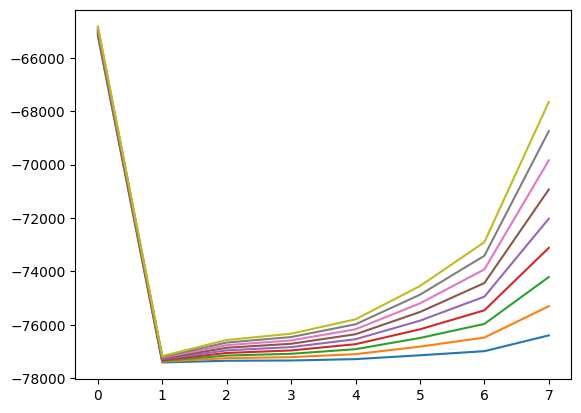

In [33]:
baye_alpha = 1e-6
mul_val = 1
brr_uncertainties = []
brr_bics = []
for com in sorted(st.track.keys()):
    brr = BayesianRidge(compute_score=True, alpha_1=baye_alpha, alpha_2=baye_alpha)
    brr.fit(X_pre[:, st.track[com][0]], y_pre)
    uncert = mul_val*np.trace(np.sqrt(brr.sigma_))
    brr_uncertainties.append(uncert)
    brr_bics.append((brr.predict(X_pre[:, st.track[com][0]]).reshape(-1, 1), 
                     np.count_nonzero(brr.coef_), 
                     uncert))
brr_uncertainties = np.array(brr_uncertainties)

power = 0
while 1:
    e = brr_uncertainties.min()*(10**power)
    if e > 1: break
    power += 1
mul_val = 10**power
brr_uncertainties = brr_uncertainties*mul_val
print(brr_uncertainties)

for kkk in range(1, 10):
    brr_bicaics = [BIC_AIC(brr_pred, y_pre, brr_com+kkk*mul_val*brr_uncert)[0] 
                   for brr_pred, brr_com, brr_uncert in brr_bics]
    print(np.argmin(brr_bicaics)+1, end=',')
    plt.plot(brr_bicaics)
plt.show()

In [34]:
### useful for checking whether it worth having function coefficienst or not? ###
# diff_lib = ps.PDELibrary(library_functions=library_functions, 
#                          function_names=library_function_names, 
#                          derivative_order=2, 
#                          spatial_grid=x, 
#                          is_uniform=True, 
#                          differentiation_method=ps., 
#                          differentiation_kwargs=differentiation_kwargs)

diff_lib = ps.PDELibrary(library_functions=library_functions, 
                         function_names=library_function_names, 
                         derivative_order=2, 
                         spatial_grid=x, 
                         is_uniform=True, 
                         differentiation_method=differentiation_method)

candidate_lib = diff_lib.fit_transform(np.expand_dims(un[:, :], -1))
candidate_lib = candidate_lib.reshape(-1, candidate_lib.shape[-1])
dynamics = diff_lib.differentiation_method(axis=1)._differentiate(un[:, :], t)
dynamics = dynamics.reshape(-1,1)

dependent = "temporal"
Theta_grouped, Ut_grouped = spatial_temporal_group(candidate_lib, dynamics, 
                                                   (len(x), len(t)), 
                                                   dependent=dependent)

com2coeff = {}
com2paracoeff = {}
for com in sorted(st.track.keys()):
    indices, _ = st.track[com]
    paracoeff = np.zeros(shape=(candidate_lib.shape[-1], len(Theta_grouped)))
    
    paracoeff[list(indices)] = np.hstack([np.linalg.lstsq(Theta_grouped[_][:, indices], 
                                                          Ut_grouped[_], 
                                                          rcond=None)[0] for _ in range(len(Theta_grouped))])
    
    coeff = np.zeros(shape=(candidate_lib.shape[-1], 1))
    coeff[list(indices)] = np.linalg.lstsq(candidate_lib[:, indices], dynamics)[0]
    coeff = np.hstack([coeff for _ in range(len(Theta_grouped))])
    
    com2coeff[com] = coeff
    com2paracoeff[com] = paracoeff

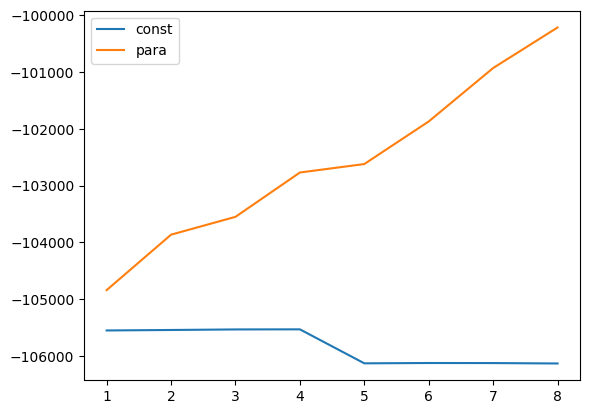

In [35]:
PDE_Losses = np.array([PDE_FIND_Loss(Theta_grouped, Ut_grouped, com2coeff[com])
                       for com in sorted(st.track.keys())])
paraPDE_Losses = np.array([PDE_FIND_Loss(Theta_grouped, Ut_grouped, com2paracoeff[com], const_coeff=False)
                       for com in sorted(st.track.keys())])

### decide whether you are dealing with functional coefficients here ###
plt.plot(sorted(st.track.keys()), PDE_Losses, label='const')
plt.plot(sorted(st.track.keys()), paraPDE_Losses, label='para')
plt.legend()
plt.show()

-0.006727176283387018


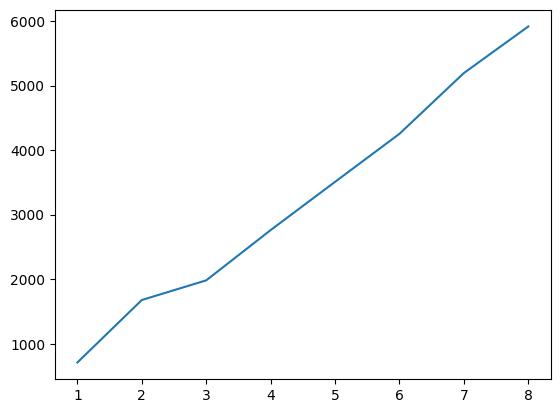

In [36]:
# 5 to 10 percent as threshold
print(np.min(paraPDE_Losses-PDE_Losses)/PDE_Losses[np.argmin(paraPDE_Losses-PDE_Losses)])
plt.plot(sorted(st.track.keys()), paraPDE_Losses-PDE_Losses)
plt.show()

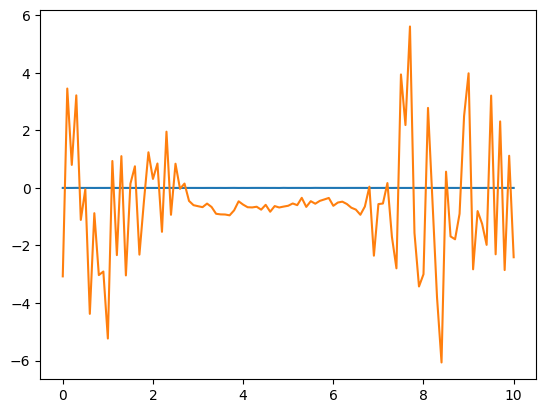

In [37]:
if dependent == "temporal":
    plt.plot(t, com2paracoeff[2][list(st.track[2][0])][0])
    plt.plot(t, com2paracoeff[2][list(st.track[2][0])][1])
elif dependent == "spatial":
    plt.plot(x, com2paracoeff[2][list(st.track[2][0])][0])
    plt.plot(x, com2paracoeff[2][list(st.track[2][0])][1])
plt.show()

In [38]:
maxi = np.max(t); mini = np.min(t)
mid = (mini+maxi)/2
ss = np.arange(0, len(t)-(list(t).index(mid)), dtype=np.int32)

com2coeff_sub = {}
for s in ss:
    t_sub_indices = [i+s for i in range(list(t).index(mid)+1)]
    t_sub = t[t_sub_indices]
    un_sub = (un.copy())[:, t_sub_indices]
    print(t_sub_indices[0], "->", t_sub_indices[-1])

    diff_lib = ps.PDELibrary(library_functions=library_functions, 
                             function_names=library_function_names, 
                             derivative_order=2, 
                             spatial_grid=x, 
                             is_uniform=True, 
                             differentiation_method=ps.SmoothedFiniteDifference)

    candidate_lib_sub = diff_lib.fit_transform(np.expand_dims(un_sub, -1))
    candidate_lib_sub = candidate_lib_sub.reshape(-1, candidate_lib_sub.shape[-1])
    dynamics_sub = diff_lib.differentiation_method(axis=1)._differentiate(un_sub, 
                                                                          t_sub).reshape(-1,1)
    
    Theta_grouped_sub, Ut_grouped_sub = spatial_temporal_group(candidate_lib_sub, dynamics_sub, 
                                                               (len(x), len(t_sub)), 
                                                               dependent=dependent)
    
    for com in sorted(st.track.keys()):
        indices, _ = st.track[com]
        
        coeff = np.hstack([np.linalg.lstsq(Theta_grouped_sub[_][:, indices], 
                                           Ut_grouped_sub[_], 
                                           rcond=None)[0] for _ in range(len(Theta_grouped_sub))])

#         coeff = np.zeros(shape=(candidate_lib_sub.shape[-1], 1))
#         coeff[list(indices)] = np.linalg.lstsq(candidate_lib_sub[:, indices], dynamics_sub)[0]
#         coeff = np.hstack([coeff for _ in range(n)])

        coeff = np.expand_dims(coeff, 0)
        if com not in com2coeff_sub: 
            com2coeff_sub[com] = coeff
        else: 
            com2coeff_sub[com] = np.vstack((com2coeff_sub[com], coeff))

0 -> 50
1 -> 51
2 -> 52
3 -> 53
4 -> 54
5 -> 55
6 -> 56
7 -> 57
8 -> 58
9 -> 59
10 -> 60
11 -> 61
12 -> 62
13 -> 63
14 -> 64
15 -> 65
16 -> 66
17 -> 67
18 -> 68
19 -> 69
20 -> 70
21 -> 71
22 -> 72
23 -> 73
24 -> 74
25 -> 75
26 -> 76
27 -> 77
28 -> 78
29 -> 79
30 -> 80
31 -> 81
32 -> 82
33 -> 83
34 -> 84
35 -> 85
36 -> 86
37 -> 87
38 -> 88
39 -> 89
40 -> 90
41 -> 91
42 -> 92
43 -> 93
44 -> 94
45 -> 95
46 -> 96
47 -> 97
48 -> 98
49 -> 99
50 -> 100


In [39]:
cvs = np.zeros((len(st.track.keys()), len(diff_lib.get_feature_names())))
for com in sorted(st.track.keys()):
    indices, _ = st.track[com]
    cv_com = np.zeros(len(diff_lib.get_feature_names()))
    
    ### treat a seq of coeff values in one horizon as a mean constant number ###
    mh_coeffs = np.mean(com2coeff_sub[com], axis=-1)
    cv_com[list(indices)] = np.abs(np.std(mh_coeffs, axis=0)/np.mean(mh_coeffs, axis=0))
    
    ### mean over the horizon axis as well
    # cv_com[list(indices)] = np.abs(com2coeff_sub[com].std(axis=0)/com2coeff_sub[com].mean(axis=0)).mean(axis=-1)
    
    cvs[com-1] = cv_com
    
cvs.sum(axis=-1)

array([ 0.9124344 ,  1.4843716 , 47.92320231, 10.71686891,  8.08162916,
        9.22558612, 11.21813619, 21.91316652])

2


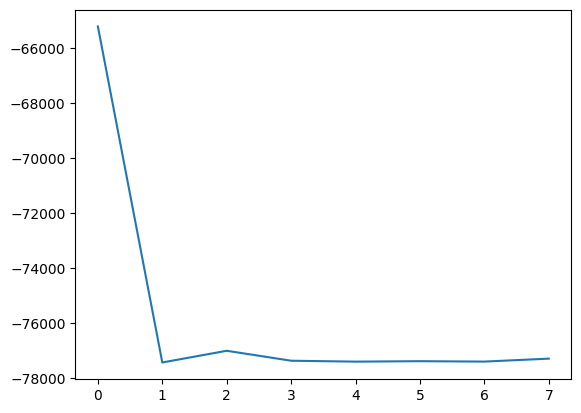

In [40]:
brr_bicaics = [BIC_AIC(brr_pred, y_pre, brr_com+cvs.sum(axis=-1)[brr_com-1])[0] 
               for brr_pred, brr_com, brr_uncert in brr_bics]
print(np.argmin(brr_bicaics)+1)
plt.plot(brr_bicaics)
plt.show()

In [41]:
raise SystemExit("Stop right here!")

SystemExit: Stop right here!

#### Denoised weak form: Tune (p, q), ws

In [ ]:
def weight_poly(x, m, k):
    """
    Polynomial piece of weighting function used to satisfy BC A = d^k/dx^k[(x^2 - 1)^m]
    x: independent variable
    m: power of base function
    k: order of derivative
    """
    a = np.zeros((2*m+1, 1)) # initial coefficient vector
    for l in range(m+1):
        a[2*l] = ((-1)**(m-l))*np.math.comb(m, l) # set polynomial coefficients
    
    c = np.zeros((2*m+1, 1)) # final coefficient vector
    for n in range(2*m-k+1):
        c[n] = a[n+k]*np.math.factorial(n+k)/np.math.factorial(n)
    
    p = 0
    for n in range(2*m-k+1):
        p += c[n]*(x**n) # final windowing function

    return p

def weight_full(k, p, x, t):
    """
    Assemble the 1D weight functions into the full weight
    k = [kx,ky,kt]: order of derivative(s)
    p = [px,py,pt]: exponents of weight polynomials
    """
    if len(k) == 3:
        wx = weight_poly(x, p[0], k[0])
        wy = weight_poly(x, p[1], k[1])
        wt = weight_poly(t, p[2], k[2])
        wX, wY, wT = np.meshgrid(wx, wy, wt)
        W = wX * wY * wT
    elif len(k) == 2:
        wx = weight_poly(x, p[0], k[0])
        wt = weight_poly(t, p[1], k[1])
        wT, wX = np.meshgrid(wt, wx)
        W = wX * wT
    
    return W, wx, wt

In [ ]:
u_weak = un.copy()
n_domain = 10000
div = 3.5
x_size, t_size = int(max(u_weak.shape)/div), int(max(u_weak.shape)/div)

xsup = np.linspace(-1,1,x_size+1)
tsup = np.linspace(-1,1,t_size+1)
S_x = 2/(dx*x_size)
S_t = 2/(dt*t_size)

In [ ]:
max_order = 2
best_loss = 1e6; best_coeff = None
for mo in range(max_order, max_order+10, 1):
    wx, wt = np.meshgrid((xsup**2-1)**mo, (tsup**2-1)**(mo-1))
    W = (wx*wt).T
    
    # Define the derivative:
    d_dx = FinDiff(0, xsup[1]-xsup[0], 1)
    d_dxx = FinDiff(0, xsup[1]-xsup[0], 2)
    d_dxxxx = FinDiff(0, xsup[1]-xsup[0], 4)
    d_dt = FinDiff(1, tsup[1]-tsup[0], 1)

    dA01 = d_dt(W)
    dA10 = d_dx(W)
    dA20 = d_dxx(W)
    dA40 = d_dxxxx(W)

    X_weak = []
    y_weak = []
    for _ in trange(n_domain):
        ix = np.random.randint(0, len(x)-x_size, size=1)[0] + np.arange(0, x_size+1)
        it = np.random.randint(0, len(t)-t_size, size=1)[0] + np.arange(0, t_size+1)

        usup = (u_weak[ix, :][:, it])

        f1 = -(1/2)*(usup**2)*dA10*S_x
        f1 = trapz(trapz(f1, tsup, dt, 1), xsup, dx, 0)

        f2 = usup*dA20*(S_x**2)
        f2 = trapz(trapz(f2, tsup, dt, 1), xsup, dx, 0)

        X_weak.append([f2, f1])

        f4 = -usup*dA01*S_t
        f4 = trapz(trapz(f4, tsup, dt, 1), xsup, dx, 0)
        y_weak.append(f4)

    X_weak = np.array(X_weak)
    y_weak = np.array(y_weak)

    coeff = np.linalg.lstsq(X_weak, y_weak, rcond=None)[0]
    loss = ((X_weak@coeff-y_weak)**2).mean()

    print(mo)
    print(loss, evaluate_coefficients(coeff))
    if loss < best_loss:
        best_loss = loss
        best_coeff = coeff
    else:
        break

best_coeff, evaluate_coefficients(best_coeff)

#### Savgol_filter

In [ ]:
wx, wt = np.meshgrid((xsup**2-1)**(mo-1), (tsup**2-1)**(mo-1))
W = wx*wt

# Define the derivative:
d_dx = FinDiff(0, xsup[1]-xsup[0], 1, acc=4)
d_dxx = FinDiff(0, xsup[1]-xsup[0], 2, acc=4)
d_dxxxx = FinDiff(0, xsup[1]-xsup[0], 4, acc=4)
d_dt = FinDiff(1, tsup[1]-tsup[0], 1, acc=4)

dA01 = d_dt(W)
dA10 = d_dx(W)
dA20 = d_dxx(W)
dA40 = d_dxxxx(W)

min_loss = 1e6; best_coeff = None
for ws in trange(3, 33, 2):
    X_weak = []
    y_weak = []
    for _ in range(n_domain):
        ix = np.random.randint(0, len(x)-x_size, size=1)[0] + np.arange(0, x_size+1)
        it = np.random.randint(0, len(t)-t_size, size=1)[0] + np.arange(0, t_size+1)
        
        usup = savgol_filter(u_weak[ix, :][:, it], ws, 2)

        f1 = -(1/2)*(usup**2)*dA10*S_x
        f1 = trapz(trapz(f1, tsup, 1), xsup, 0)

        f2 = usup*dA20*(S_x**2)
        f2 = trapz(trapz(f2, tsup, 1), xsup, 0)

        X_weak.append([f2, f1])

        f4 = -usup*dA01*S_t
        f4 = trapz(trapz(f4, tsup, 1), xsup, 0)
        y_weak.append(f4)

    X_weak = np.array(X_weak)
    y_weak = np.array(y_weak)
    
    coeff = np.linalg.lstsq(X_weak, y_weak, rcond=None)[0]
    loss = ((X_weak@coeff-y_weak)**2).mean()
    if loss < min_loss:
        min_loss = loss
        best_coeff = coeff

# (0.04606205985549505, 0.03820344646573992)
min_loss, best_coeff, evaluate_coefficients(best_coeff)

#### wiener

In [ ]:
min_loss = 1e6; best_coeff = None
for ws in trange(3, 33, 1):
    X_weak = []
    y_weak = []
    for _ in range(n_domain):
        ix = np.random.randint(0, len(x)-x_size, size=1)[0] + np.arange(0, x_size+1)
        it = np.random.randint(0, len(t)-t_size, size=1)[0] + np.arange(0, t_size+1)
        
        usup = wiener(u_weak[ix, :][:, it], ws)

        f1 = -(1/2)*(usup**2)*dA10*S_x
        f1 = trapz(trapz(f1, tsup, 1), xsup, 0)

        f2 = usup*dA20*(S_x**2)
        f2 = trapz(trapz(f2, tsup, 1), xsup, 0)

        X_weak.append([f2, f1])

        f4 = -usup*dA01*S_t
        f4 = trapz(trapz(f4, tsup, 1), xsup, 0)
        y_weak.append(f4)

    X_weak = np.array(X_weak)
    y_weak = np.array(y_weak)
    
    coeff = np.linalg.lstsq(X_weak, y_weak, rcond=None)[0]
    loss = ((X_weak@coeff-y_weak)**2).mean()
    if loss < min_loss:
        min_loss = loss
        best_coeff = coeff

# (0.4027586839031899, 0.06266909774915452)
min_loss, best_coeff, evaluate_coefficients(best_coeff)

In [ ]:
raise SystemExit("Stop right here!")

In [ ]:
# X_pre = np.zeros(X_pre.shape)
# y_pre = np.zeros(y_pre.shape)
# n_times = 10
# weak_coeffs = []
# for _ in range(n_times):
#     weak_pde_lib = ps.WeakPDELibrary(library_functions=[lambda x: x, lambda x: x * x], 
#                                      function_names=[lambda x: x, lambda x: x + x], 
#                                      derivative_order=diff_order, p=diff_order, 
#                                      spatiotemporal_grid=XT, 
#                                      include_bias=False, is_uniform=True, K=10000, 
#                                      differentiation_method=differentiation_method, 
#                                      differentiation_kwargs=differentiation_kwargs, 
#                                      cache=True
#                                     )
#     kwargs = {'fit_intercept':False, 'copy_X':True, 'normalize_columns':False}
#     # Apply moving horizon to un is an interesting idea.
#     X_pre_sub, y_pre_sub, fns = ps_features(un, t, weak_pde_lib, kwargs)
#     X_pre = X_pre + X_pre_sub
#     y_pre = y_pre + y_pre_sub
#     optimizer = L0BNB(max_nonzeros=2, lam=1e-3, is_normal=True, normalize_columns=False)
#     n_ensemble_models = 50
#     model = ps.SINDy(feature_library=weak_pde_lib, optimizer=optimizer, 
#                      differentiation_method=differentiation_method, 
#                      cache=True,
#                      feature_names=['u'])
#     model.fit(np.expand_dims(un, -1), t=dt, ensemble=True, 
#               library_ensemble=True, n_candidates_to_drop=1, n_models=n_ensemble_models)
#     ols_model, eff_rhs_indices = model.validate_coef_list()[0]
#     print(np.array([convert2latex(f) for i,f in enumerate(model.get_feature_names()) if i in eff_rhs_indices]))
#     print(ols_model.params)
#     # percent_coeff = evaluate_coefficients(ols_model.params)
#     # print(percent_coeff)
#     # if percent_coeff[0] > 100: break
#     weak_coeffs.append(ols_model.params)
# weak_coeffs = np.array(weak_coeffs)
# avg_weak_coeff = np.mean(weak_coeffs, axis=0)
# X_pre = X_pre/n_times
# y_pre = y_pre/n_times

In [ ]:
# RDAE 5e-0: cv = 0.005062929348375081, 0.011023507990422338
# RDAE 1e-0: cv = 0.004408008789094885, 0.00910193468516509
# RDAE 5e-1: cv = 0.003467511174737858, 0.008040505161991068
# RDAE 5e-2: cv = 0.004305311364345706, 0.007809099375818377

# cv_abs = (weak_coeffs.std(axis=0)/np.abs(weak_coeffs.mean(axis=0))).mean()
# cv = (weak_coeffs.std(axis=0)/weak_coeffs.mean(axis=0)).mean()
# cv, cv_abs

In [ ]:
# 50 percent noise
# Robust PCA: (14.745720655392669, 6.347415766367691)
# RDAE failed...

# 40 percent noise
# Robust PCA: (14.818002368919029, 7.899799685479938)
# RDAE 5e-0: (2.9505659028666087, 1.8024006266427972)
# RDAE 1e-0: (3.2008235132427463, 2.56690175990938)
# RDAE 5e-1: (2.469185388081714, 1.7166311808760781)
# RDAE 5e-2: (6.015975755333656, 5.859365864415776)
# RDAE 5e-3: Failed

# evaluate_coefficients(avg_weak_coeff)

In [ ]:
def percent_coeff(pred, ground):
    return 100*np.abs(pred-ground)/np.abs(ground)
print(avg_weak_coeff)
errs = percent_coeff(avg_weak_coeff, np.array([0.1, -1]))
errs.mean(), errs.std()

In [ ]:
# print(np.linalg.lstsq(X_pre[:, [3,4]], y_pre, rcond=None)[0].flatten())
# evaluate_coefficients(np.linalg.lstsq(X_pre[:, [3,4]], y_pre, rcond=None)[0].flatten())

#### Save

In [ ]:
best_subsets = sorted([indices for _, (indices, _) in st.track.items()], key=lambda _: len(_))
tmp = np.zeros((len(best_subsets), X_pre.shape[-1]))
for i in range(len(best_subsets)):
    tmp[i:i+1, :][0, best_subsets[i]] = 1.0
best_subsets = tmp.astype(np.float32)
del tmp

pms_data = {nameof(un): un, 
            nameof(X_pre): X_pre, 
            nameof(y_pre): y_pre, 
            nameof(best_subsets): best_subsets}
pms_data

In [ ]:
basic_vars = {'u'}
encoded_feature_names = []
for feature in model.get_feature_names():
    out_feature = []
    last_index = -1
    for i, c in enumerate(feature):
        if i+1 < len(feature) and feature[i+1] in basic_vars:
            last_index = i
            out_feature.append(c+'*')
    out_feature.append(feature[last_index+1:])
    encoded_feature_names.append(''.join(out_feature))
encoded_feature_names = np.array(encoded_feature_names)
encoded_feature_names.tolist()

In [ ]:
for com in sorted(st.track.keys()):
    indices, _ = st.track[com]
    expr = '+'.join(encoded_feature_names[list(indices)])
    print(expr)
    print('----------')
encoded_pde_names = ['+'.join(encoded_feature_names[list(indices)]) for _, (indices, _) 
                     in sorted(st.track.items())]

In [ ]:
import yaml
from omegaconf import OmegaConf
yml = {}
yml["encoded_feature_names"] = encoded_feature_names.tolist()
yml["encoded_pde_names"] = encoded_pde_names
yml["information_criterion_score"] = [float(ic) for _, (_, ic) in st.track.items()]

#### Save files for training PINNs & DeepONets

In [ ]:
fp1 = "../Burgers_exp/IPI_output_files/PMS_data.h5"
fp2 = "../Burgers_exp/IPI_output_files/encoded_pde_names.yaml"
fp1, fp2

In [ ]:
h5file(file_path=fp1, cdict=pms_data, mode='w')
OmegaConf.save(config=OmegaConf.create(yml), f=fp2)

In [ ]:
OmegaConf.load(fp2)

In [ ]:
h5file(file_path=fp1, mode='r', return_dict=False)